In [35]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import ast
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,Report Info,Section,Data Description,Data Value,Uncertainty on the data (%),Unit,EmissionFactor,Amortization - NBR year,Acquisition Year
0,159,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Mobility,Car - team building,4103.180371,0.2,vehicle.km,Car - France - 0.384 - vehicle.km - 0.6,NaN,NaN
1,18,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Products & Services,Cardboard,132.394960,0.2,ton,Textbooks - France - 40.0 - ton - 0.5,NaN,NaN
2,52,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Waste Consumption,Average household waste,73.288790,0.2,ton,Residual Waste - France - 362.0 - ton - 0.87,NaN,NaN
3,64,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Products & Services,Daily internet consumption,163.111265,0.1,FTE,Digital consumption - France - 49.2 - FTE - 1.0,NaN,NaN
4,9,"{'name': 'Tapio', 'location': 'Paris', 'date':...",Energy Consumption,Grey electricity - Homeworking,1890.280000,0.5,kWh,Grey Electricity - France - 0.205 - kWh - 0.15,NaN,NaN


In [37]:
data.describe()

,Unnamed: 0,Data Value,Uncertainty on the data (%),EmissionFactor,Amortization - NBR year,Acquisition Year,date
count,187.000000,1.870000e+02,187.000000,0.0,24.0,24.0,86
mean,93.000000,inf,0.163636,NaN,4.0,2017.0,2023-06-24 06:08:22.325581312
min,0.000000,5.923124e+01,0.050000,NaN,4.0,2017.0,2022-01-01 00:00:00
25%,46.500000,1.877451e+02,0.050000,NaN,4.0,2017.0,2022-04-02 06:00:00
50%,93.000000,3.722861e+04,0.200000,NaN,4.0,2017.0,2023-01-01 00:00:00
75%,139.500000,1.330886e+05,0.200000,NaN,4.0,2017.0,2024-01-01 00:00:00
max,186.000000,inf,0.500000,NaN,4.0,2017.0,2025-01-01 00:00:00
std,54.126395,NaN,0.102331,NaN,0.0,0.0,NaN


Extraction de la date d'aprés la clonne "Report Info"

In [5]:
def extract_date(report_info):
    try:

        report_dict = ast.literal_eval(report_info)
        return report_dict.get("date")
    except (ValueError, SyntaxError):
        return None

data['date'] = data['Report Info'].apply(extract_date)
data['date'] = pd.to_datetime(data['date'], format='%Y', errors='coerce')

Supprimer les duplications

In [6]:
data.drop_duplicates(inplace=True)

La gestion des valeurs manquantes

In [7]:
for col in ['Data Value', 'Uncertainty on the data (%)', 'EmissionFactor', 'Acquisition Year']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna({'Data Value': data['Data Value'].median(),
             'Uncertainty on the data (%)': data['Uncertainty on the data (%)'].median()}, inplace=True)

In [8]:
data['Unit'] = data['Unit'].str.lower()
data['Section'] = data['Section'].str.title()

**Connexion SQlite**

In [9]:
conn = sqlite3.connect('emissions.db')
cursor = conn.cursor()

In [10]:
data.to_sql('emissions', conn, if_exists='replace', index=False)

187

Creation de la table

In [11]:
table_creation_query = '''
CREATE TABLE IF NOT EXISTS emissions (
    report_name TEXT,
    location TEXT,
    date DATE,
    section TEXT,
    data_description TEXT,
    data_value REAL,
    uncertainty REAL,
    unit TEXT,
    emission_factor REAL,
    amortization TEXT,
    acquisition_year INTEGER
);
'''
cursor.execute(table_creation_query)

**Analyse des données**

Calcul des émissions annuelles pour Bruxelles

In [12]:
query = """
SELECT strftime('%Y', date) as year, SUM("Data Value") as total_emissions
FROM emissions
WHERE "Report Info" LIKE '%Bruxelles%'
GROUP BY year
ORDER BY year;
"""
annual_emissions = pd.read_sql_query(query, conn)

In [13]:
print(annual_emissions)

   year  total_emissions
0  None              inf
1  2022              inf
2  2023     8.142042e+04
3  2024              inf
4  2025     9.395501e+04


Remplacer les valeurs inf par la médiane

In [14]:
median_value = annual_emissions[np.isfinite(annual_emissions['total_emissions'])]['total_emissions'].median()
annual_emissions['total_emissions'] = annual_emissions['total_emissions'].replace([np.inf, -np.inf], median_value)

In [15]:
annual_emissions['total_emissions'].fillna(0, inplace=True)


<ipython-input-15-d6130568f74d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  annual_emissions['total_emissions'].fillna(0, inplace=True)


In [16]:
annual_emissions['total_emissions'] = annual_emissions['total_emissions'].apply(
    lambda x: median_value if not np.isfinite(x) else x
)


In [17]:
annual_emissions = annual_emissions[np.isfinite(annual_emissions['total_emissions'])]

Nettoyer les données pour la visualisation et la modélisation

In [18]:
annual_emissions.dropna(subset=['year', 'total_emissions'], inplace=True)
annual_emissions['year'] = annual_emissions['year'].astype(int)
annual_emissions = annual_emissions[np.isfinite(annual_emissions['total_emissions'])]
annual_emissions = annual_emissions[annual_emissions['total_emissions'] < 1e6]

Unifier les unités

In [19]:
unique_units = data['Unit'].unique()
print(unique_units)


['vehicle.km' 'ton' 'fte' 'kwh' 'unit' 'gb' 'k€' 'room per night' 'km']


In [20]:
def normalize_units(row):
    if row['Unit'] == 'vehicle.km':
        return row['Data Value'], 'km'
    elif row['Unit'] == 'ton':
        return row['Data Value'] * 1000, 'kg'
    elif row['Unit'] == 'k€':
        return row['Data Value'] * 1000, '€'
    elif row['Unit'] in ['kwh', 'unit', 'gb', 'room per night', 'fte', 'km']:
        return row['Data Value'], row['Unit']
    else:
        return row['Data Value'], 'unknown'


data[['Data Value', 'Normalized Unit']] = data.apply(
    lambda row: pd.Series(normalize_units(row)), axis=1
)



In [22]:
print(data[['Data Value', 'Unit', 'Normalized Unit']].head())

      Data Value        Unit Normalized Unit
0    4103.180371  vehicle.km              km
1  132394.960000         ton              kg
2   73288.790120         ton              kg
3     163.111265         fte             fte
4    1890.280000         kwh             kwh


In [21]:
unknown_units = data[data['Normalized Unit'] == 'unknown']
print(unknown_units)

Empty DataFrame
Columns: [Unnamed: 0, Report Info, Section, Data Description, Data Value, Uncertainty on the data (%), Unit, EmissionFactor, Amortization - NBR year, Acquisition Year, date, Normalized Unit]
Index: []


**Visualisation**

Données corrigées :
   year  total_emissions
1  2022     87687.716148
2  2023     81420.419923
3  2024     87687.716148
4  2025     93955.012373


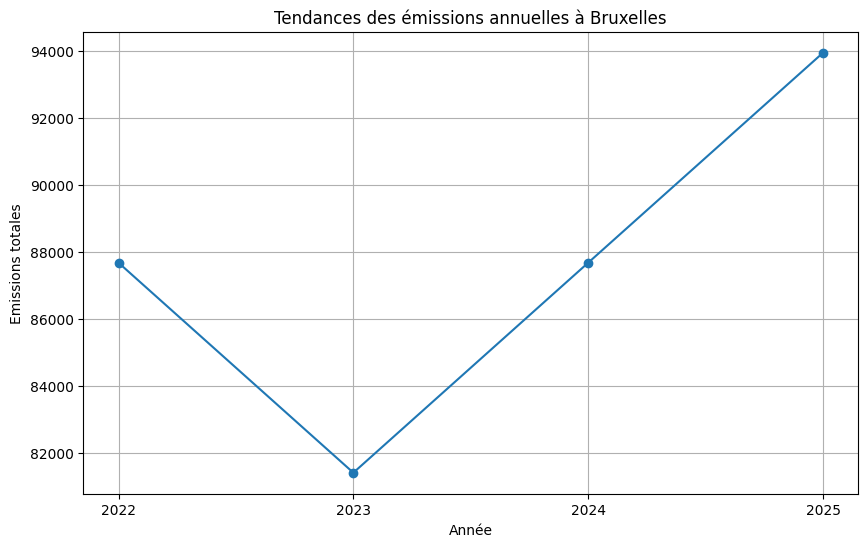

In [23]:
print("Données corrigées :")
print(annual_emissions)

plt.figure(figsize=(10, 6))
plt.plot(annual_emissions['year'], annual_emissions['total_emissions'], marker='o')
plt.title('Tendances des émissions annuelles à Bruxelles')
plt.xlabel('Année')
plt.ylabel('Emissions totales')
plt.grid(True)
plt.xticks(annual_emissions['year'])
plt.show()

Modélisation **prédictive**

Préparer les données pour la régression

In [24]:
X = annual_emissions['year'].astype(int).values.reshape(-1, 1)
y = annual_emissions['total_emissions'].values

In [25]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

Prévision pour 2026

In [26]:
future_year = np.array([[2026]])
future_prediction = model.predict(future_year)

Évaluation du modèle

In [27]:
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")


RMSE : 7162.62
MAE : 7162.62


In [29]:
print(f"Prévision des émissions pour 2026 : {future_prediction[0]:.2f}")

Prévision des émissions pour 2026 : 93955.01


Récupérer les coefficients du modèle

In [31]:
a = model.coef_[0]
b = model.intercept_


print(f"Pente (a) : {a:.2f}")
print(f"Interception (b) : {b:.2f}")


Pente (a) : 1790.66
Interception (b) : -3533914.17


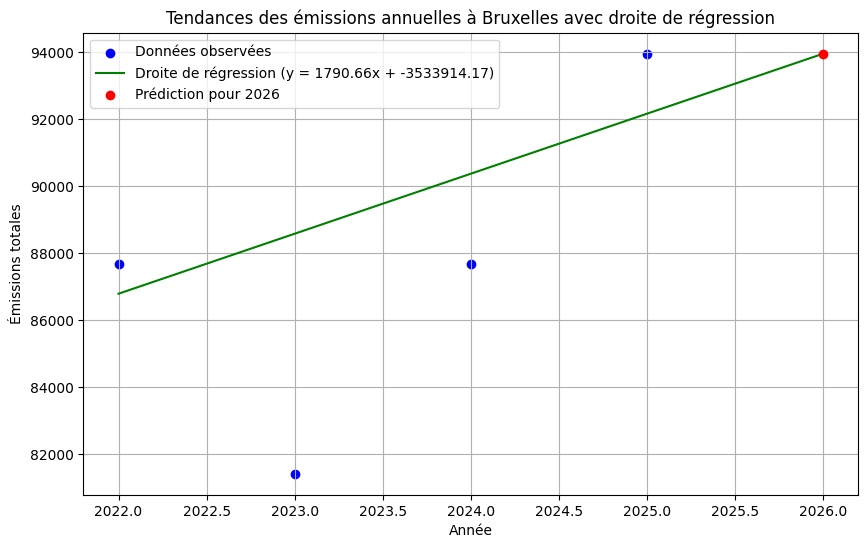

In [36]:
plt.figure(figsize=(10, 6))

plt.scatter(annual_emissions['year'], annual_emissions['total_emissions'], color='blue', label='Données observées')

x_line = np.arange(annual_emissions['year'].min(), 2027)
y_line = a * x_line + b
plt.plot(x_line, y_line, color='green', label=f'Droite de régression (y = {a:.2f}x + {b:.2f})')

plt.scatter([2026], [future_prediction[0]], color='red', label='Prédiction pour 2026', zorder=5)

plt.title('Tendances des émissions annuelles à Bruxelles avec droite de régression')
plt.xlabel('Année')
plt.ylabel('Émissions totales')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
y_pred = model.predict(X)


mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Métriques du modèle de régression linéaire :")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"Coefficient de détermination (R^2) : {r2:.2f}")


Métriques du modèle de régression linéaire :
Mean Absolute Error (MAE) : 3133.65
Root Mean Squared Error (RMSE) : 3953.66
Coefficient de détermination (R^2) : 0.20


Diagramme qui inclut également la prédiction pour 2026

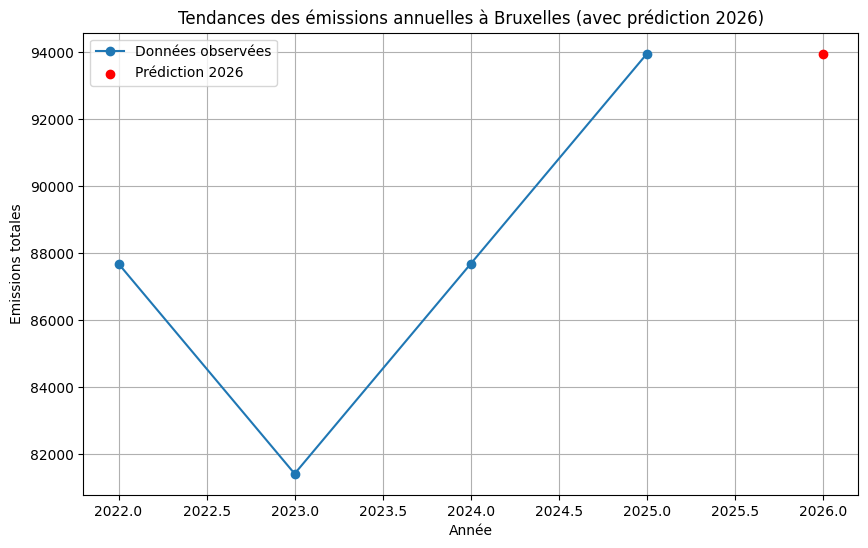

In [30]:
future_data = pd.DataFrame({
    'year': [2026],
    'total_emissions': [future_prediction[0]]
})

# Combiner les données historiques et la prédiction
all_emissions = pd.concat([annual_emissions, future_data], ignore_index=True)

plt.figure(figsize=(10, 6))
plt.plot(annual_emissions['year'], annual_emissions['total_emissions'], marker='o', label='Données observées')
plt.scatter(future_data['year'], future_data['total_emissions'], color='red', label='Prédiction 2026', zorder=5)
plt.title('Tendances des émissions annuelles à Bruxelles (avec prédiction 2026)')
plt.xlabel('Année')
plt.ylabel('Emissions totales')
plt.grid(True)
plt.legend()
plt.show()
